In [59]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import precision_recall_fscore_support, make_scorer, recall_score, f1_score, confusion_matrix, precision_score, balanced_accuracy_score
from sklearn.metrics import fbeta_score, classification_report


from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from libs.print_cm import print_cm
from libs.loader import load_malicious

         

from sklearn.model_selection import learning_curve, validation_curve

In [50]:
# df = pd.read_csv("data/malicious_01.csv")
# Xdf = df.drop(columns=["INCIDENT_ID","DATE", "MALICIOUS_OFFENSE"])
# y_mal = df["MALICIOUS_OFFENSE"]
# Xdf['X_12'] = np.nan_to_num(Xdf['X_12'])
# _X, _y = Xdf.values, y_mal.values

# # minMaxNorm = MinMaxScaler()
# # X = minMaxNorm.fit_transform(_X)
# # # pd.DataFrame(X)

# # labelEncoder = LabelEncoder()
# # y_pre = labelEncoder.fit_transform(_y)
# # y = 1 - y_pre
# # pd.DataFrame({'y':y,'y2':y_pre})

# y = 1 - _y.astype('int32')
# X = _X

X,y = load_malicious()
# help(SVC)

In [51]:
#WHAT I DID here - I set looped kernels, linear, sigmoid, poly
# kernels give 0 recall score, excpet for sigmoid
# I set the class_weight to balanced and got good recall, but both class labels were hit 50/50
# I set C down to 0.25 and good good score of recall 0.63

#second pass, ran through the randomsarch with max_itr = 1000, found a range of C values, used one C value of 2.15, then started 
# moving the max_iter value
svc = SVC(kernel='linear',C=10.0, class_weight='balanced', max_iter=20000, random_state=0)

# scorer = make_scorer(precision_score, pos_label=0 )
scorer = make_scorer(recall_score)
# scorer = make_scorer(recall_score,average='weighted')
# scorer = make_scorer(f1_score, average='weighted' )
# scorer = make_scorer(f1_score, pos_label=1)

strat_cv = StratifiedKFold(3, shuffle=True,  random_state=0)

parameters = {'C':np.logspace(-1, 2, 10)}

svc_rand = RandomizedSearchCV(
    svc,
    parameters,
    n_iter=10,
    scoring=scorer,
    cv=strat_cv,
    n_jobs=-1,
    verbose=1,
    random_state=0
)


In [52]:
svc_rand.fit(X,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packag

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=SVC(C=10.0, class_weight='balanced',
                                 kernel='linear', max_iter=20000,
                                 random_state=0),
                   n_jobs=-1,
                   param_distributions={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ])},
                   random_state=0, scoring=make_scorer(recall_score),
                   verbose=1)

In [53]:
less_5 = pd.DataFrame(svc_rand.cv_results_)['rank_test_score'] <= 5

filtered_series = pd.DataFrame(svc_rand.cv_results_)[less_5].filter(['params','rank_test_score'])
sorted_series =  (filtered_series.sort_values(by=['rank_test_score']))
out_rows = [r for r in sorted_series.values]
# type(pd.DataFrame(mlp_rand.cv_results_)[less_5]['params'])
for r in out_rows:
    print( r[1],r[0])

pd.DataFrame(svc_rand.cv_results_)[less_5]

1 {'C': 0.1}
2 {'C': 4.6415888336127775}
3 {'C': 10.0}
3 {'C': 21.54434690031882}
3 {'C': 46.41588833612777}
3 {'C': 100.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.059079,0.017264,0.401240,0.005032,0.1,{'C': 0.1},0.640449,0.524345,0.468165,0.544320,0.071739,1
5,1.607895,0.037194,0.204787,0.013847,4.641589,{'C': 4.6415888336127775},0.610487,0.573034,0.430712,0.538077,0.077444,2
6,1.604810,0.039145,0.205035,0.019036,10.0,{'C': 10.0},0.539326,0.505618,0.441948,0.495630,0.040377,3
7,1.621593,0.049441,0.213947,0.013904,21.544347,{'C': 21.54434690031882},0.539326,0.505618,0.441948,0.495630,0.040377,3
8,1.507225,0.018646,0.140118,0.006604,46.415888,{'C': 46.41588833612777},0.539326,0.505618,0.441948,0.495630,0.040377,3
9,1.430506,0.026989,0.113398,0.014025,100.0,{'C': 100.0},0.539326,0.505618,0.441948,0.495630,0.040377,3


In [44]:
cv_target = cross_validate(svc, X, y, cv=3, scoring=scorer)
cv_target

/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'fit_time': array([1.20619297, 1.21818018, 1.23358107]),
 'score_time': array([0.15800095, 0.152915  , 0.16884398]),
 'test_score': array([0.45786517, 0.27247191, 0.38202247])}

In [45]:
svc.fit(X,y)

/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(C=10.0, class_weight='balanced', kernel='linear', max_iter=20000,
    random_state=0)

In [46]:
svc.get_params()
# svc.coef_

{'C': 10.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': 20000,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [54]:
scorer

make_scorer(recall_score)

In [55]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=0)
svc.fit(X_train,y_train)
pass

/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [56]:
def stats_pac( label, estimator, X_data, y_data ):
    predicted = estimator.predict(X_data)
    print ('****** %s ******' % label)
    cm = confusion_matrix(y_data, predicted)
    print ('Confusion matrix')
    print_cm(cm, labels=['0','1'])
    
    print ('Recall - label 0: %0.4f'% recall_score(y_data, predicted, pos_label=0))
    print ('Recall - label 1: %0.4f'% recall_score(y_data, predicted))

    print ('Precsion - label 0: %0.4f'% precision_score(y_data, predicted, pos_label=0))
    print ('Precsion - label 1: %0.4f'% precision_score(y_data, predicted))
    
    sample_wt = [ 3 if i == 1 else 1 for i in predicted]
    print ('F1 Score macro: %0.4f'% f1_score(y_data, predicted, average='macro', sample_weight=sample_wt ))
    print ('F1 Score - label 0 : %0.4f'% f1_score(y_data, predicted, pos_label=0 ))
    print ('F1 Score - label 1 : %0.4f'% f1_score(y_data, predicted, pos_label=1 ))
    print ('F1 Score - weighted avg : %0.4f'% f1_score(y_data, predicted, average='weighted' ))
    print ('F1 Beta - b=2 weighted avg : %0.4f'% fbeta_score(y_data,predicted, average='weighted', beta=2))
    
    print (classification_report(y_data, predicted, labels=[1,0]))


stats_pac('Knn plain - Train', svc, X_train, y_train)
stats_pac('Knn plain - Validation', svc, X_test, y_test)

****** Knn plain - Train ******
Confusion matrix
              0     1 
        0 10572  3100 
        1   371   270 
Recall - label 0: 0.7733
Recall - label 1: 0.4212
Precsion - label 0: 0.9661
Precsion - label 1: 0.0801
F1 Score macro: 0.4148
F1 Score - label 0 : 0.8590
F1 Score - label 1 : 0.1346
F1 Score - weighted avg : 0.8265
F1 Beta - b=2 weighted avg : 0.7795
              precision    recall  f1-score   support

           1       0.08      0.42      0.13       641
           0       0.97      0.77      0.86     13672

    accuracy                           0.76     14313
   macro avg       0.52      0.60      0.50     14313
weighted avg       0.93      0.76      0.83     14313

****** Knn plain - Validation ******
Confusion matrix
              0     1 
        0  2640   779 
        1    98    62 
Recall - label 0: 0.7722
Recall - label 1: 0.3875
Precsion - label 0: 0.9642
Precsion - label 1: 0.0737
F1 Score macro: 0.4085
F1 Score - label 0 : 0.8576
F1 Score - label 1 : 0.12

## hyperparams

In [88]:
svc2 = SVC(kernel='linear', class_weight='balanced', max_iter=200000, random_state=0)
range_list = ['linear', 'rbf', 'sigmoid','poly']

In [74]:
strat_cv = StratifiedKFold(3, shuffle=True,  random_state=0)
svc_train_scores, svc_test_scores = validation_curve(
    svc2, X, y, param_name="kernel", param_range=range_list,
    scoring=scorer, cv=strat_cv, n_jobs=-1)

/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [75]:
train_scores_mean = np.mean(svc_train_scores, axis=1)
test_scores_mean = np.mean(svc_test_scores, axis=1)
# print (range_list.shape,train_scores_mean.shape,test_scores_mean.shape)
df_1 = pd.DataFrame({'x':range_list,'train':train_scores_mean,'test':test_scores_mean} )
df_1

,x,train,test
0,linear,0.538702,0.528090
1,rbf,0.820849,0.816479
2,sigmoid,0.456305,0.479401
3,poly,0.867041,0.861423


In [70]:
svc3 = SVC(kernel='poly',C=10.0, class_weight='balanced', max_iter=200000, random_state=0)
range_list2 = np.logspace(-1, 2, 15)

In [71]:
svc_train_scores3, svc_test_scores3 = validation_curve(
    svc3, X, y, param_name="C", param_range=range_list2,
    scoring=scorer, cv=strat_cv, n_jobs=-1)

/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-pac

In [72]:
train_scores_mean3 = np.mean(svc_train_scores3, axis=1)
test_scores_mean3 = np.mean(svc_test_scores3, axis=1)
# print (range_list.shape,train_scores_mean.shape,test_scores_mean.shape)
df_3 = pd.DataFrame({'x':range_list2,'train':train_scores_mean3,'test':test_scores_mean3} )
df_3

,x,train,test
0,0.100000,0.851436,0.851436
1,0.163789,0.848315,0.848939
2,0.268270,0.849563,0.845194
3,0.439397,0.853308,0.851436
4,0.719686,0.855181,0.852684
5,1.178769,0.868914,0.863920
6,1.930698,0.880150,0.873908
7,3.162278,0.888265,0.877653
8,5.179475,0.888265,0.885144
9,8.483429,0.901373,0.892634


In [82]:
svc4 = SVC(kernel='poly', class_weight='balanced', max_iter=200000, random_state=0)
range_list4 = np.linspace(1,10,10)

In [83]:
svc_train_scores4, svc_test_scores4 = validation_curve(
    svc4, X, y, param_name="degree", param_range=range_list4,
    scoring=scorer, cv=strat_cv, n_jobs=-1)

/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/sdodge/work/omscs/cs7641/cs7641_assignments/env3.9.7/lib/python3.9/site-pac

In [84]:
train_scores_mean4 = np.mean(svc_train_scores4, axis=1)
test_scores_mean4 = np.mean(svc_test_scores4, axis=1)
# print (range_list.shape,train_scores_mean.shape,test_scores_mean.shape)
df_4 = pd.DataFrame({'x':range_list4,'train':train_scores_mean4,'test':test_scores_mean4} )
df_4

,x,train,test
0,1.0,0.652310,0.644195
1,2.0,0.866417,0.861423
2,3.0,0.867041,0.861423
3,4.0,0.887640,0.878901
4,5.0,0.911361,0.902622
5,6.0,0.920724,0.912609
6,7.0,0.928839,0.911361
7,8.0,0.933833,0.916355
8,9.0,0.948190,0.915106
9,10.0,0.953808,0.915106


Text(0.5, 1.0, 'SVM Validation curve:\nPolynomial Degree')

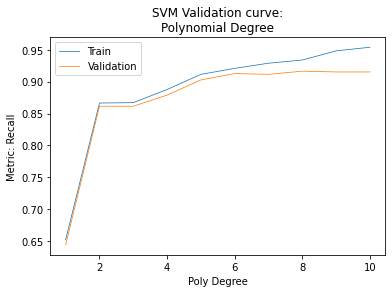

In [86]:
axs = plt.gca()
axs.plot(df_4['x'], df_4['train'], label='Train', linewidth=0.75)
axs.plot(df_4['x'], df_4['test'], label='Validation', linewidth=0.75)
axs.legend(); axs.set_ylabel("Metric: Recall"); axs.set_xlabel("Poly Degree")
axs.set_title('SVM Validation curve:\nPolynomial Degree')

In [115]:
## Plot iterations
svc5 = SVC(kernel='poly', class_weight='balanced', degree=6, random_state=0)
range_list = np.linspace(2, 10000, 15).astype('int32')
range_list = np.logspace(1,5,15).astype('int32')
range_list


array([    10,     19,     37,     71,    138,    268,    517,   1000,
         1930,   3727,   7196,  13894,  26826,  51794, 100000],
      dtype=int32)

In [ ]:
svc_train_scores5, svc_test_scores5 = validation_curve(
    svc5, X, y, param_name="max_iter", param_range=range_list,
    scoring=scorer, cv=strat_cv, n_jobs=-1)
print("done")

In [117]:

train_scores_mean5 = np.mean(svc_train_scores5, axis=1)
test_scores_mean5 = np.mean(svc_test_scores5, axis=1)
print (range_list.shape,train_scores_mean5.shape,test_scores_mean5.shape)
df_5 = pd.DataFrame({'x':range_list,'train':train_scores_mean5,'test':test_scores_mean5} )
df_5

(15,) (15,) (15,)


,x,train,test
0,10,0.978777,0.971286
1,19,0.978777,0.971286
2,37,0.973783,0.971286
3,71,0.964419,0.965044
4,138,0.936954,0.938826
5,268,0.942572,0.942572
6,517,0.954432,0.952559
7,1000,0.879526,0.886392
8,1930,0.930712,0.932584
9,3727,0.929463,0.936330


Text(0.5, 1.0, 'SVM Iterations Curve')

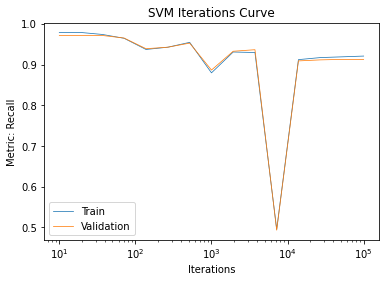

In [119]:
axs = plt.gca()
axs.plot(df_5['x'], df_5['train'], label='Train', linewidth=0.75)
axs.plot(df_5['x'], df_5['test'], label='Validation', linewidth=0.75)
axs.legend(); axs.set_ylabel("Metric: Recall"); axs.set_xlabel("Iterations")
axs.set_xscale("log")
axs.set_title('SVM Iterations Curve')